# Kanji Radical Match

Loading data, training, and output.

In [1]:
import utils as u
import torch.nn as nn
import torch
import numpy as np
from utils import KanjiFFNN
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss

In [2]:
# eng_to_rads = u.load_eng_to_rads()
eng_to_rads = u.json_to_dict('./data/english_to_radicals.json')
eng_tens, rad_tens, eng_vocab, rad_vocab = u.dict_to_tensors(eng_to_rads)

In [3]:
print("Vocabulary size:", len(eng_vocab))
print("Radical vocabulary size:", len(rad_vocab))

Vocabulary size: 12091
Radical vocabulary size: 253


In [4]:
# Print a small sample of our data
print(eng_tens[:5])
print(eng_vocab[:5])
print(rad_tens[:5])
print(rad_vocab[:5])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['"male" principle' '"summer"' '%' "'kimono' sleeve" "(Cantonese) don't!"]
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['ノ' 'ハ' 'マ' 'ユ' 'ヨ']


In [5]:
# Example
print(len(u.get_tensor_from_word("eight", eng_tens, eng_vocab)))

12091


In [6]:
e2r_model = KanjiFFNN(eng_tens.size(0), rad_tens.size(-1))
criterion = nn.BCELoss()
optimizer = optim.Adam(e2r_model.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
e2r_model.eval()

KanjiFFNN(
  (input): Linear(in_features=12091, out_features=300, bias=True)
  (output): Linear(in_features=300, out_features=253, bias=True)
)

In [7]:
epochs = 10

history = e2r_model.train_fit(eng_tens, rad_tens, optimizer, criterion, epochs=epochs, scheduler=lr_scheduler, verbose=True)

Epoch: 1  Loss: 0.16734516620635986  Accuracy: 5.160698039864362%
Epoch: 2  Loss: 0.15924492478370667  Accuracy: 4.895045901910512%
Epoch: 3  Loss: 0.15224091708660126  Accuracy: 7.257464229592259%
Epoch: 4  Loss: 0.09773602336645126  Accuracy: 15.691671491191796%
Epoch: 5  Loss: 0.04998236522078514  Accuracy: 17.10677363328095%
Epoch: 6  Loss: 0.04944709688425064  Accuracy: 16.072698701513524%
Epoch: 7  Loss: 0.02583356201648712  Accuracy: 14.161442395169962%
Epoch: 8  Loss: 0.02174997702240944  Accuracy: 14.639649325944918%
Epoch: 9  Loss: 0.016085049137473106  Accuracy: 14.571830286990323%
Epoch: 10  Loss: 0.007173965685069561  Accuracy: 15.012654040195187%


In [8]:
torch.save(e2r_model, "./models/model_v3.pt")

In [9]:
torch.save(e2r_model.state_dict(), "./models/model_v3_state_dict.pt")

In [10]:
loaded_model = KanjiFFNN(eng_tens.size(1), rad_tens.size(1))
loaded_model.load_state_dict(torch.load("./models/model_v3_state_dict.pt"))
loaded_model.eval()

KanjiFFNN(
  (input): Linear(in_features=12091, out_features=300, bias=True)
  (output): Linear(in_features=300, out_features=253, bias=True)
)

In [11]:
# For direct usage
loaded_model = e2r_model

In [12]:
input_word = "eight"
test_tensor = u.get_tensor_from_word(input_word, eng_tens, eng_vocab)
res = loaded_model(test_tensor)
print(res)

tensor([3.1392e-03, 9.9313e-01, 5.5249e-05, 5.3314e-04, 4.4841e-05, 8.8403e-04,
        4.6599e-06, 1.2957e-03, 7.2347e-05, 4.3040e-05, 3.0061e-06, 7.6151e-06,
        3.0137e-06, 4.4815e-06, 3.7503e-06, 1.1594e-06, 1.1437e-06, 8.5976e-05,
        7.0783e-06, 7.1293e-05, 1.5123e-06, 4.7957e-06, 1.3255e-05, 1.5377e-04,
        7.3112e-07, 2.1450e-04, 1.7578e-06, 3.4786e-05, 4.2807e-07, 4.3387e-07,
        1.0954e-04, 5.7236e-06, 1.3408e-05, 3.0550e-05, 9.6729e-01, 3.8300e-06,
        9.5522e-01, 9.8539e-01, 8.2814e-04, 2.2430e-05, 3.8561e-04, 1.0938e-04,
        1.3801e-05, 5.3809e-06, 1.7344e-04, 2.9354e-04, 1.3720e-04, 2.1276e-05,
        1.6214e-05, 9.9386e-01, 7.4669e-05, 3.5427e-05, 4.2182e-06, 1.1066e-04,
        6.4588e-06, 3.4681e-05, 8.0981e-05, 9.2078e-07, 3.8578e-05, 4.1911e-06,
        9.9338e-05, 4.8201e-05, 6.0336e-05, 3.7783e-05, 1.2684e-06, 1.4733e-06,
        6.6427e-06, 1.6511e-04, 1.5677e-05, 3.0568e-05, 1.0699e-06, 1.8971e-05,
        7.2487e-06, 4.9405e-05, 8.9361e-

In [13]:
output_probs = res.detach().numpy().squeeze()
radical_probs = [(radical, prob) for radical, prob in zip(np.array(rad_vocab), output_probs)]
sorted_radical_probs = sorted(radical_probs, key=lambda x: x[1], reverse=True)
print(sorted_radical_probs[:15])

[('口', 0.9938617), ('ハ', 0.99313194), ('勹', 0.98538625), ('扎', 0.9819212), ('刈', 0.9672948), ('力', 0.95522434), ('ノ', 0.0031391901), ('个', 0.0012956711), ('一', 0.00088403), ('勿', 0.0008281371), ('貝', 0.00080323475), ('已', 0.00078210654), ('疔', 0.0006872185), ('歹', 0.0006636082), ('ユ', 0.0005331366)]


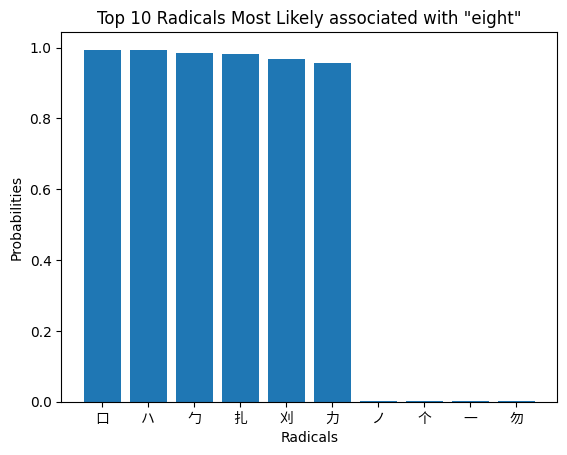

In [17]:
TOP_TAKE = 10
fprop = fm.FontProperties(fname='NotoSansCJKtc-Regular.otf')

radicals, probabilities = zip(*sorted_radical_probs)

radicals_top = list(radicals[:TOP_TAKE])
probabilities_top = list(probabilities[:TOP_TAKE])

fig, axs = plt.subplots()
axs.bar(range(TOP_TAKE), probabilities_top)
axs.set_xticks(range(TOP_TAKE), radicals_top, fontproperties=fprop)
axs.set_xlabel('Radicals')
axs.set_ylabel('Probabilities')
axs.set_title(f'Top {TOP_TAKE} Radicals Most Likely associated with \"{input_word}\"')

plt.show()

In [15]:
with torch.no_grad():
    preds = loaded_model(eng_tens)
    preds = (preds > 0.5)
    print('Precision:', precision_score(rad_tens, preds, average='micro'))
    print('Recall:', recall_score(rad_tens, preds, average='micro'))
    print('F1 Score:', f1_score(rad_tens, preds, average='micro'))
    print('Accuracy:', accuracy_score(rad_tens, preds))
    print("Ham", hamming_loss(rad_tens, preds))

Precision: 0.9994874423372629
Recall: 0.7957606072265556
F1 Score: 0.8860644457715576
Accuracy: 0.7780994127863701
Ham 0.005737779676713775
